In [82]:
import numpy as np
from PIL import Image
import torch, json, os, random
import kornia as K
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
model_path = '/home/ubuntu/models/classification/model.pth'
conf_path = '/home/ubuntu/models/classification/config.json'
data_path = '/mnt/data/flowers/train'

In [21]:
import os
import mimetypes
from pathlib import Path
from functools import partial

get_ext = lambda x: [i for i,j in mimetypes.types_map.items() if j.startswith(x)]

image_ext = get_ext('image')
video_ext = get_ext('video')
text_ext = get_ext('video')
audio_ext = get_ext('audio')

join_path = lambda x,y: Path(os.path.join(x, y))

def get_files(root, file_type=None, recursive=True):
    files = []
    if file_type: file_type = tuple(file_type)
    if not recursive:
        files.extend([join_path(root, i) for i in os.listdir(root) if str(i).lower().endswith(file_type)])
    else:
        for p, d, fs in os.walk(root):
            if file_type:
                files.extend([join_path(p, f) for f in fs if str(f).lower().endswith(file_type)])
            else:
                files.extend([join_path(p, f) for f in fs])
    return files

get_image_files = partial(get_files, file_type = image_ext)
get_video_files = partial(get_files, file_type = video_ext)
get_text_files = partial(get_files, file_type = text_ext)
get_audio_files = partial(get_files, file_type = audio_ext)

In [60]:
class ImageDataset(Dataset):
    def __init__(self, fs, img_sz):
        self.fs = fs
        self.img_sz = img_sz
        
    def __getitem__(self, idx):
        item = self.fs[idx]
        img = Image.open(item).convert('RGB')
        img = np.array(img.resize((self.img_sz, self.img_sz)))
        return torch.from_numpy(img).permute(2,0,1), item.stem
    
    def __len__(self): return len(self.fs)

In [98]:
class ClassificationPredict:
    def __init__(self, model_path, conf_path):
        self.load_conf(conf_path)
        self.model = self.load_model(model_path)
        self.enc = {i:j for i,j in enumerate(self.conf['Classes'])}
        self.bin = len(self.conf['classes']) == 2
        
    def load_conf(self, p):
        with open(p, 'r') as f:
            self.conf = json.load(f)
            
    def load_model(self, o):
        m = torch.load(o)
        m = m.float()
        m = m.eval()
        return m
    
    def single_predict(self, o):
        img = Image.open(o).convert('RGB')
        img_sz = self.conf['Image Size']
        img = np.array(img.resize((img_sz, img_sz)))
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).cuda().unsqueeze(0)
        img = self.normalize(img)
        with torch.no_grad():
            pred = self.model(img)
        return self.enc[pred.argmax().item()]
        
    def normalize(self, o):
        return K.normalize(o/255.0,
                        mean=torch.tensor((0.485, 0.456, 0.406)),
                        std=torch.tensor((0.229, 0.224, 0.225)))
        
    def predict_dl(self, dl):
        predictions = dict()
        with torch.no_grad():
            for xb, n in dl:
                pred = self.model(self.normalize(xb.cuda()))
                pred = pred.detach().cpu().numpy().argmax(axis=-1)
                temp = {j:self.enc[i] for i,j in zip(pred.squeeze().tolist(), n)}
                predictions.update(temp)
        df = pd.DataFrame({'fname': list(predictions.keys()),
                           'classes': list(predictions.values())})
        return df
            
    def predict_folder(self, path):
        fs = get_image_files(path)
        ds = ImageDataset(fs, img_sz = self.conf['Image Size'])
        dl = DataLoader(ds, batch_size=32, num_workers=2, pin_memory=True)
        return self.predict_dl(dl)

In [99]:
c = ClassificationPredict(model_path, conf_path)

In [100]:
fs = get_image_files(data_path)

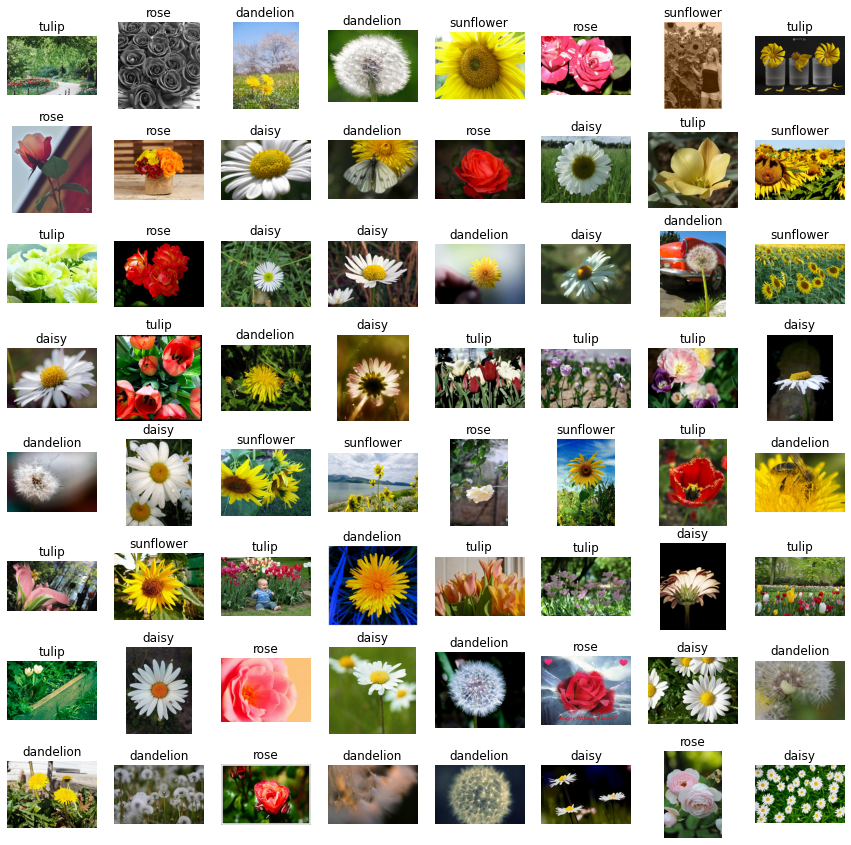

In [101]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for k, ax in enumerate(axes.ravel()):
    f = random.choice(fs)
    o = c.single_predict(f)
    img = Image.open(f)
    ax.imshow(img)
    ax.set_title(o)
    ax.axis('off')

## batch predictions

In [102]:
o = c.predict_folder(data_path)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [103]:
o

,fname,classes
0,5139969871_c9046bdaa7_n,sunflower
1,7652532108_01ef94c476,sunflower
2,20938724084_7fe6bf87ae_n,sunflower
3,14741813110_94964c39e2_n,sunflower
4,5043404000_9bc16cb7e5_m,sunflower
...,...,...
4309,5717951287_124cac32b1_n,tulip
4310,4599815420_8ee42c2382,tulip
4311,5208680166_c4372477ef_n,tulip
4312,6931715360_34edc5a372_m,tulip
